## Computer Vision Project

## Image-Based Classification: Distracted Driver Identification & Classification

### VGG16 (Batch 60 - Adam - α = 0.005)

In this project, our dataset consists of images showcasing drivers engaged in various activities within their vehicles. The aim is to use these images to accurately predict the driver's specific activity.

The activities, which serve as the prediction classes, are as follows:

- c0: Normal driving
- c1: Texting - Right hand
- c2: Phone call - Right hand
- c3: Texting - Left hand
- c4: Phone call - Left hand
- c5: Radio operation
- c6: Drinking
- c7: Reaching behind
- c8: Personal grooming or makeup
- c9: Talking to a passenger


In [1]:
# Importing the necessary libraries and modules
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import PIL
import tensorflow as tf
import os
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score
import random
from PIL import Image
import cv2
from keras.applications.vgg16 import VGG16
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model

from keras.models import Sequential
from keras.models import load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aycabasaran","key":"f9a907b17592ba8a8aed79fefa1b403f"}'}

In [3]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c state-farm-distracted-driver-detection

100% 4.00G/4.00G [03:15<00:00, 20.8MB/s]
100% 4.00G/4.00G [03:15<00:00, 22.0MB/s]


In [5]:
!unzip state-farm-distracted-driver-detection.zip -d distracted_driver_dataset

Streaming output truncated to the last 5000 lines.
  inflating: distracted_driver_dataset/imgs/train/c7/img_56636.jpg  
  inflating: distracted_driver_dataset/imgs/train/c7/img_56661.jpg  
  inflating: distracted_driver_dataset/imgs/train/c7/img_56699.jpg  
  inflating: distracted_driver_dataset/imgs/train/c7/img_56717.jpg  
  inflating: distracted_driver_dataset/imgs/train/c7/img_56724.jpg  
  inflating: distracted_driver_dataset/imgs/train/c7/img_56768.jpg  
  inflating: distracted_driver_dataset/imgs/train/c7/img_56779.jpg  
  inflating: distracted_driver_dataset/imgs/train/c7/img_56849.jpg  
  inflating: distracted_driver_dataset/imgs/train/c7/img_56899.jpg  
  inflating: distracted_driver_dataset/imgs/train/c7/img_56938.jpg  
  inflating: distracted_driver_dataset/imgs/train/c7/img_5706.jpg  
  inflating: distracted_driver_dataset/imgs/train/c7/img_57076.jpg  
  inflating: distracted_driver_dataset/imgs/train/c7/img_57122.jpg  
  inflating: distracted_driver_dataset/imgs/train/c7/

In [6]:
!ls "/content/distracted_driver_dataset/imgs"

test  train


In [7]:
# Defining the Training & Testing images folder path in order to feed the different models
images_path_train = "/content/distracted_driver_dataset/imgs/train"
images_path_test = "/content/distracted_driver_dataset/imgs/test"


## Data Exploration

In this section, we delve into our dataset to get a better understanding of the data we are working with. This involves inspecting the volume of the data, evaluating the distribution of classes, and possibly unveiling any potential biases that might affect our model's learning process.

### Dataset Size

Here, we take a look at the overall size of our dataset. This includes the total number of images, the number of images in each class, as well as the dimensionality of these images.

### Class Distribution

An understanding of the class distribution is essential as it could inform us about any class imbalance in our data. Class imbalance could potentially bias our model's predictions. As such, we'll visualize the distribution of the classes to see if any particular driver activity is over- or under-represented.


In [8]:
# Defining a function to count the number of images that are available in the provided directories
def count_files(path):
    count = 0
    for root, dirs, files in os.walk(path):
        count += len(files)
    return count

In [9]:
# Identifying the number of images in the training set
train_file_count = count_files(images_path_train)
print(f" The Training set contains {train_file_count} images.")

 The Training set contains 22424 images.


In [10]:
# Identifying the number of images in the testing set
test_file_count = count_files(images_path_test)
print(f" The Testing set contains {test_file_count} images.")

 The Testing set contains 79726 images.


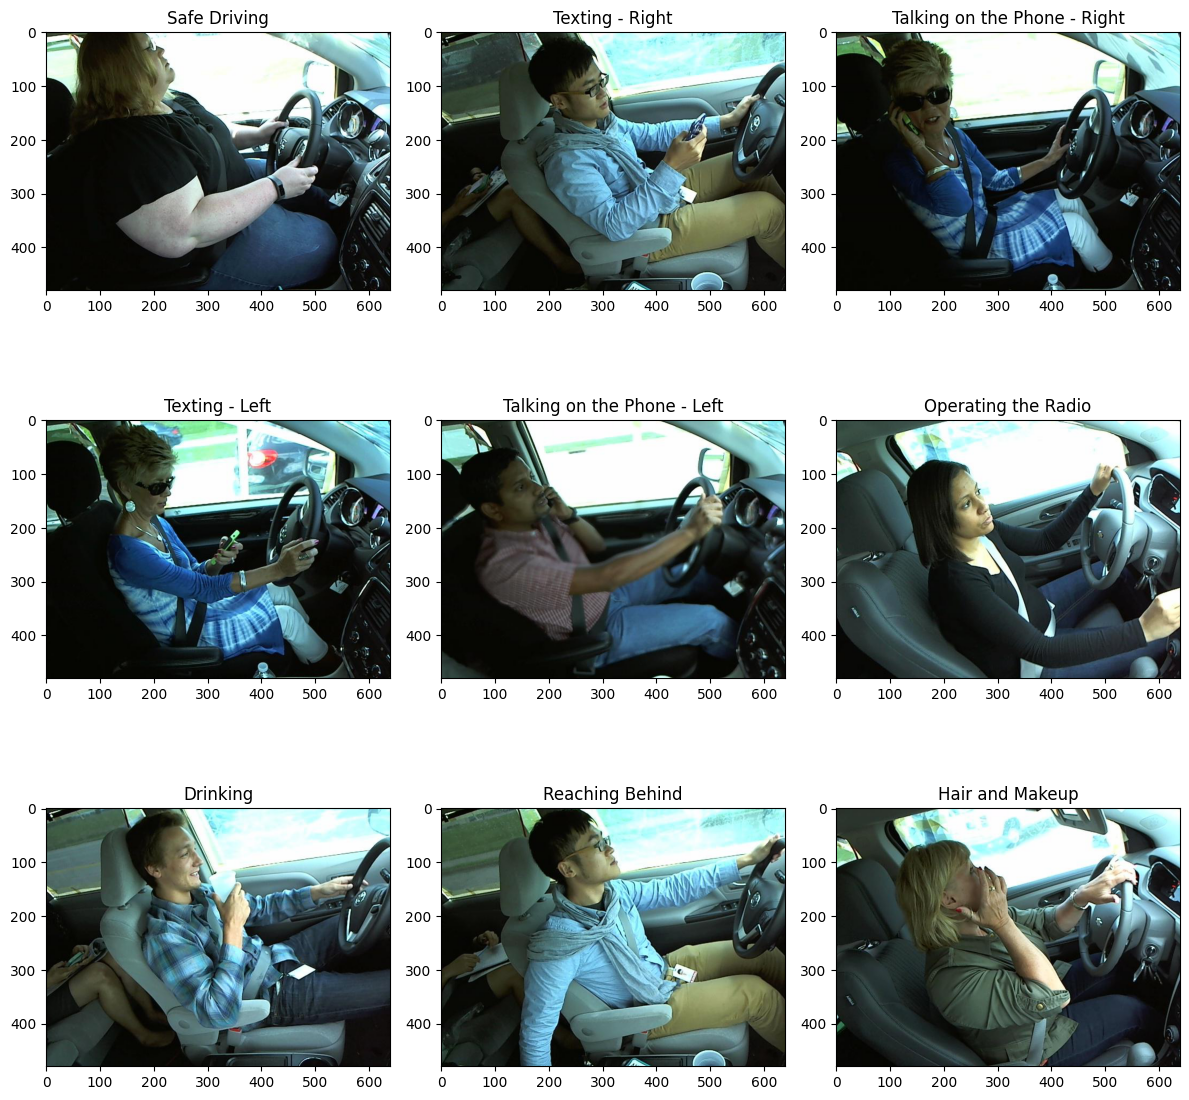

In [11]:
# Identifying the image directory where the images are stored
image_dir = images_path_train

# Mapping of activity titles for each type
activity_classes = {
    "c0": "Safe Driving",
    "c1": "Texting - Right",
    "c2": "Talking on the Phone - Right",
    "c3": "Texting - Left",
    "c4": "Talking on the Phone - Left",
    "c5": "Operating the Radio",
    "c6": "Drinking",
    "c7": "Reaching Behind",
    "c8": "Hair and Makeup",
    "c9": "Talking to Passenger"
}

# Initializing a subplot to display the images
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
axes = axes.ravel()

# Looping through each activity type and displaying one image with the corresponding title
for i, activity_type in enumerate(sorted(activity_classes.keys())[:9]):

    # Getting the path of the first image for the activity type
    activity_dir = os.path.join(image_dir, activity_type)
    image_name = os.listdir(activity_dir)[0]
    image_path = os.path.join(activity_dir, image_name)

    # Loading and displaying the images
    image = Image.open(image_path)
    axes[i].imshow(image)
    axes[i].set_title(activity_classes[activity_type])
    axes[i].axis('on')

# Adjusting image spacing and displaying the plots
plt.tight_layout()
plt.show()

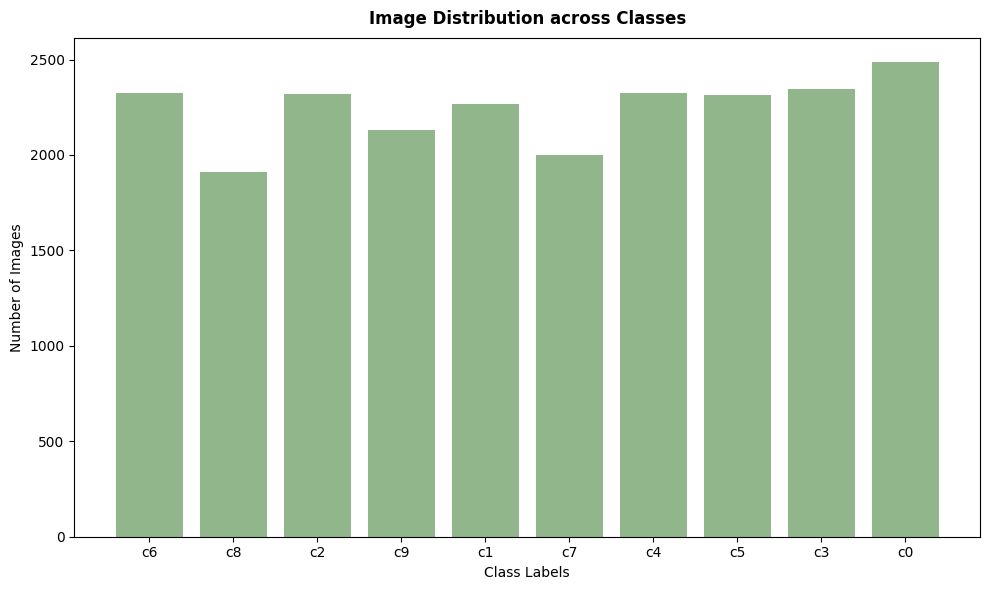

In [12]:
# Initializing empty lists to store class labels and corresponding image counts
class_labels = []
image_counts = []

# Iterating through each subdirectory in the train directory and appending the different counts
for subdir in os.listdir(image_dir):
    subdir_path = os.path.join(image_dir, subdir)
    if os.path.isdir(subdir_path):
        class_labels.append(subdir)
        image_counts.append(len(os.listdir(subdir_path)))

# Plotting a vertical bar chart with the class data distribution
plt.figure(figsize=(10, 6))
plt.bar(class_labels, image_counts, color = '#92b68b')
plt.xlabel("Class Labels")
plt.ylabel("Number of Images")
plt.title("Image Distribution across Classes", fontweight='bold', pad=10)
plt.tight_layout()
plt.show()

## Developing the Model - VGG16

In our study, we will be employing VGG16, a model renowned for its effectiveness in image classification tasks.

### Data Preprocessing

For VGG16, images are preprocessed to ensure optimal model performance. This includes a crucial normalization step, which adjusts pixel values to fall within a 0 to 1 range. Normalization enhances gradient convergence and improves the model's generalization.

### Setting Hyperparameters

Key hyperparameters need to be determined before training. These include the batch size, dictating the number of samples processed before the model's parameters are updated, and the image size, selected to balance the retention of spatial details against computational efficiency. Specifically for VGG16, images are resized to 224 x 224 x 3 (RGB).

### Splitting Training and Validation Data

To provide a reliable estimate of the model's performance on unseen data and to prevent overfitting, a validation set is created. In this project, we'll reserve 30% of the images for validation, and the remaining 70% will be utilized for training the model.

In [74]:
# Normalizing pixel values by dviding feature values by 255
# Holding back 30% of the images for validation
print("Getting Data...")
datagen = ImageDataGenerator(rescale=1./255,
                             validation_split=0.3)

Getting Data...


In [75]:
# Defining the image dimensions
img_size = (224,224)

# Defining the batch size
batch_size = 60

# The folder contains a subfolder for each class of shape
classes = sorted(os.listdir(images_path_train))
print(classes)

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']


In [76]:
# Setting the Training data
print("Preparing training dataset...")
train_generator = datagen.flow_from_directory(
    images_path_train,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

# Setting the Validation data
print("Preparing validation dataset...")
validation_generator = datagen.flow_from_directory(
    images_path_train,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Preparing training dataset...
Found 15702 images belonging to 10 classes.
Preparing validation dataset...
Found 6722 images belonging to 10 classes.


### VGG16 Model Overview

**Structure:**

VGG16 comprises several layers:

- **Convolutional Layers**: The model consists of multiple convolutional layers, where the number of filters increases progressively (from 64 to 512). Each convolutional layer utilizes a 3x3 kernel size, 1x1 stride, 'same' padding, and ReLU activation.
  
- **Max Pooling Layers**: Following every few convolutional layers, a max pooling layer is applied with a 2x2 pool size and stride.

- **Flattening Layer**: After the last max pooling layer, a flattening layer is added to reshape the tensor output into a vector.

- **Dense Layers**: The model concludes with three dense layers. The first two have 4096 units each with ReLU activation, while the final dense layer contains units equal to the number of classes and uses softmax activation for multiclass classification.

**Strengths:**

- Efficient in feature extraction due to multiple convolutional layers with small filter sizes.
- Supports transfer learning because of pre-training on the ImageNet dataset.

**Weaknesses:**

- High computational power required due to the large number of parameters.
- Prone to overfitting on small datasets.

**Hyperparameters:**

The model uses:
- **Optimizer**: Adam optimizer, which adapts learning rates for different parameters.
- **Loss Function**: Categorical Cross Entropy, suitable for multiclass classification problems.
- **Learning Rate**: Set to 0.005, found optimal in previous models.




In [77]:
# Loading the base model, not including its final connected layer
# Setting the input shape to match the one from the training images
base_model = VGG16(weights='imagenet', include_top=False, input_shape=train_generator.image_shape)

In [78]:
# Freezing the already-trained layers in the base model 3
for layer in base_model.layers:
    layer.trainable = False

In [79]:
# Creating the final layers for the classification of the input images
x = base_model.output
x = Flatten()(x)
prediction_layer = Dense(len(classes), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=prediction_layer)

In [80]:
# Defining the optimizer
opt = tf.optimizers.Adam(learning_rate=0.005)

In [81]:
# Compiling the model for categorical multi-class classification
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

print(model.summary())

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

## Model Training Phase

At this juncture, the VGG16 model, with its predefined layers, is set for the training phase using the image dataset. This learning process involves three iterations, commonly referred to as epochs, and the images are fed into the model in batches of 60.

The training phase is vital for the model to progressively learn and refine its ability to predict the correct classes of the given images. Notably, 30% of the entire dataset is set aside for validation and is not involved in the model's training.

At the end of each epoch, the loss function evaluates the model's predictions by measuring the degree of error, or loss, between the model's predictions and the actual image classes. This quantified loss serves to guide the adjustment of the model's weights, continually enhancing its predictive accuracy throughout the epochs.


In [82]:
# Train the model over 3 epochs
num_epochs = 3
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    epochs = num_epochs)

Epoch 1/3
261/261 [==============================] - 118s 444ms/step - loss: 1.7538 - accuracy: 0.8733 - val_loss: 0.0563 - val_accuracy: 0.9848
Epoch 2/3
261/261 [==============================] - 117s 448ms/step - loss: 0.0215 - accuracy: 0.9941 - val_loss: 0.0218 - val_accuracy: 0.9951
Epoch 3/3
261/261 [==============================] - 117s 449ms/step - loss: 0.0042 - accuracy: 0.9991 - val_loss: 0.0242 - val_accuracy: 0.9921



### Post-training Analysis

Upon completion of training, it is critical to evaluate the progression of the loss function's decrease, as well as to ascertain whether the model is overfitting - implying that the model has learned the training data too well but struggles to apply this learning to unseen data. This overfitting scenario can be identified by a consistent decline in training loss even after the validation loss has plateaued or begun to rise.

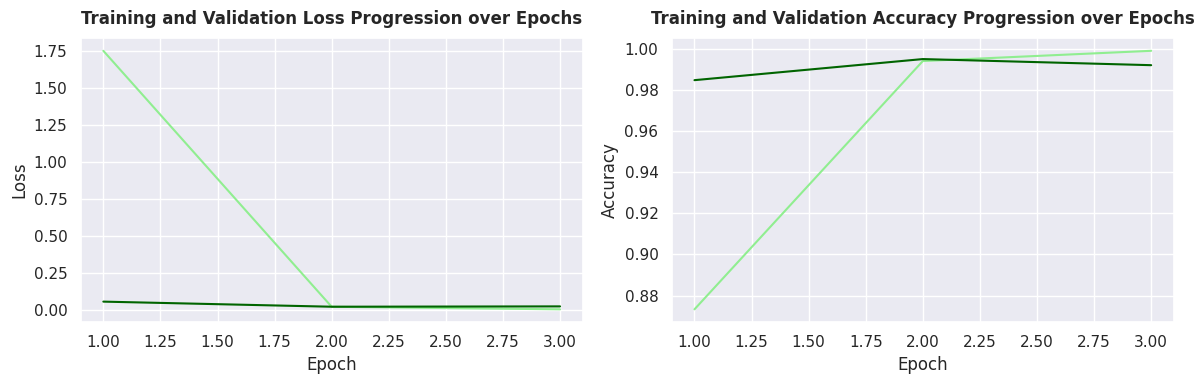

In [83]:
# Plotting the loss
plt.subplot(1, 2, 1)
epoch_nums = range(1, num_epochs + 1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss, color='lightgreen', label='Training Data')
plt.plot(epoch_nums, validation_loss, color='darkgreen', label='Validation Data')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Training and Validation Loss Progression over Epochs", fontweight='bold', pad=10)

# Plotting the accuracy
plt.subplot(1, 2, 2)
training_acc = history.history["accuracy"]
validation_acc = history.history["val_accuracy"]
plt.plot(epoch_nums, training_acc, color='lightgreen', label='Training Data')
plt.plot(epoch_nums, validation_acc, color='darkgreen', label='Validation Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Training and Validation Accuracy Progression over Epochs", fontweight='bold', pad=10)

plt.tight_layout()
plt.show()

### Grad-CAM Visualization

Grad-CAM technique offers an insightful way to reveal the regions of the images that the model emphasizes while making its decisions.

The highlighted areas extend beyond the subjects, indicating that seemingly unrelated sections, like parts outside the car window, play a role in the decision-making process of the model. This underlines the importance of adequate image pre-processing and comprehensive data augmentation in future model iterations.

1/1 [==============================] - 0s 21ms/step


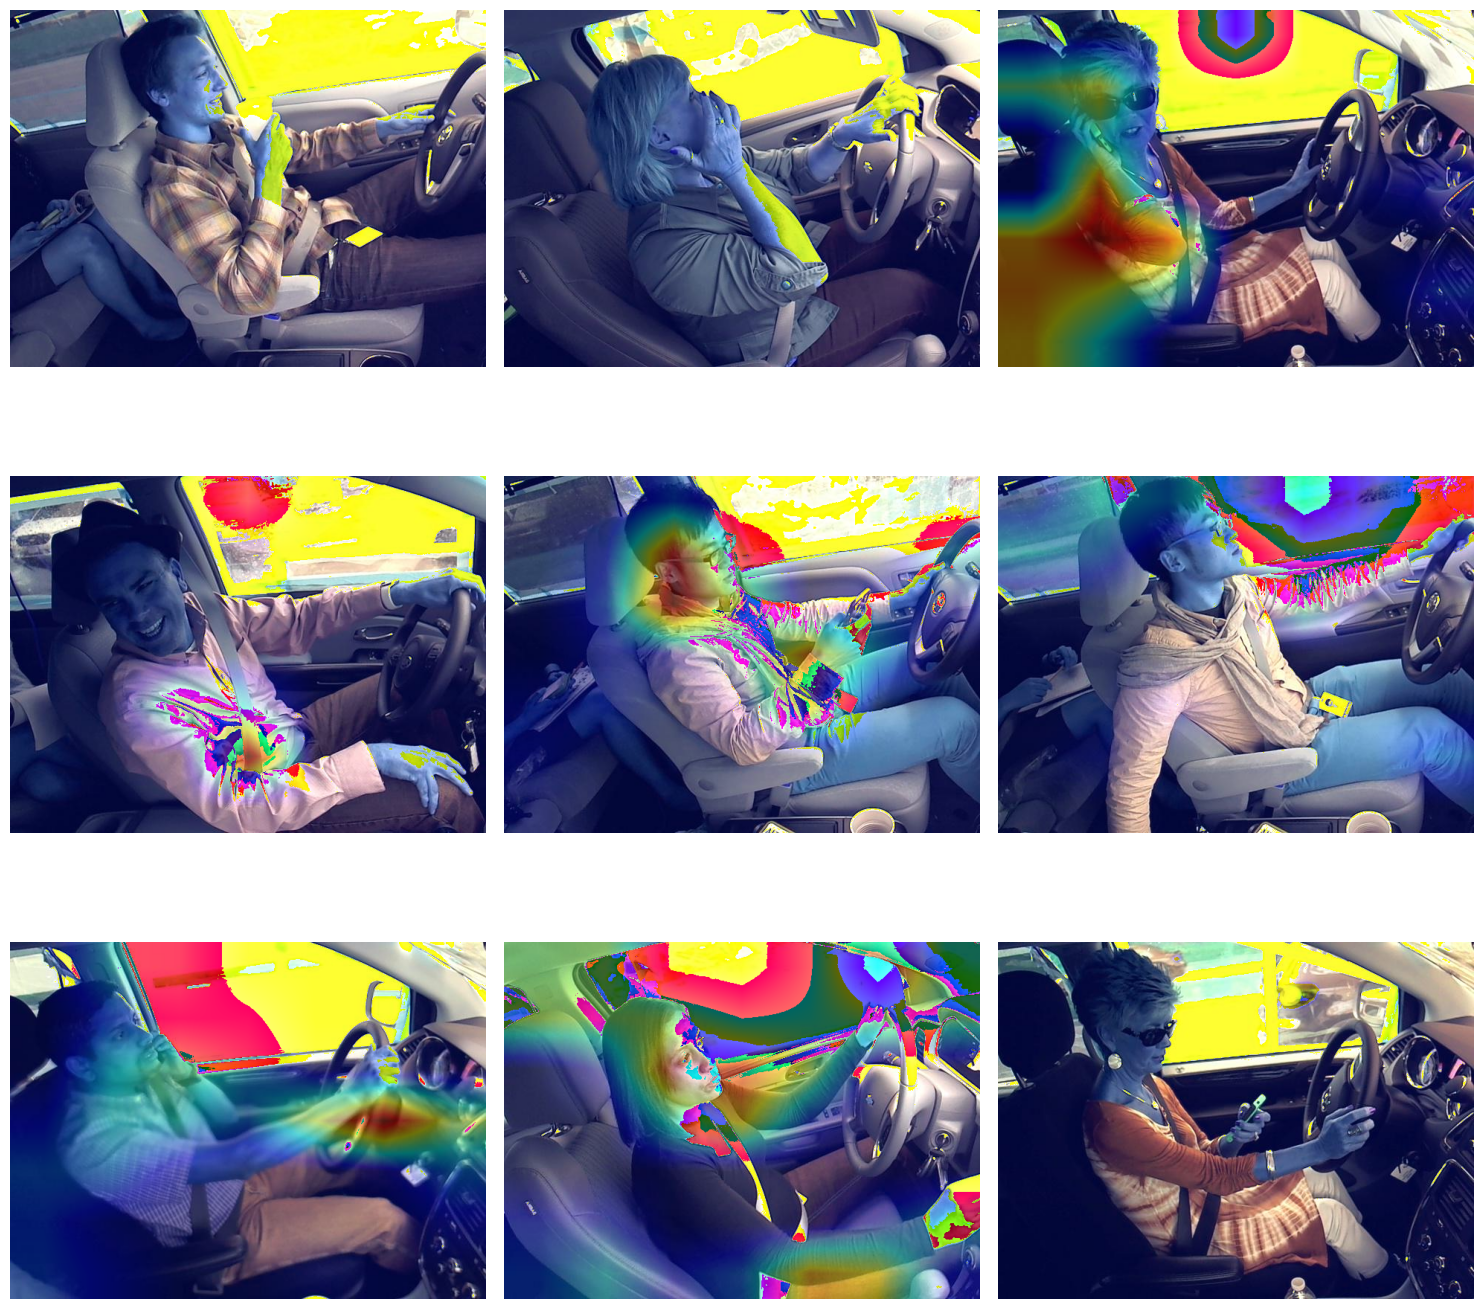

In [85]:
# Creating a list for the images
img_paths = []

# Assigning the parent directory of the images
parent_dir = images_path_train

# Looping through each subdirectory in the parent directory
for sub_dir in os.listdir(parent_dir):

    # Getting the path of the first image in the subdirectory
    sub_dir_path = os.path.join(parent_dir, sub_dir)
    # Checking if it is a directory.
    if os.path.isdir(sub_dir_path):
        image_name = os.listdir(sub_dir_path)[0]
        image_path = os.path.join(sub_dir_path, image_name)

        img_paths.append(image_path)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.ravel()

# Performing data transformation to match the image characteristics with which the model was trained
for i, img_path in enumerate(img_paths[:9]):  # Limit to first 9 images
    img = load_img(img_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img.astype('float32') / 255

    preds = model.predict(img)
    class_idx = np.argmax(preds[0])

    last_conv_layer = model.get_layer("block5_pool")

    grad_model = Model(
        [model.inputs],
        [last_conv_layer.output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img)
        class_channel = preds[:, class_idx]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    heatmap = cv2.resize(heatmap.numpy(), (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img

    axes[i].imshow(cv2.cvtColor(np.uint8(superimposed_img), cv2.COLOR_BGR2RGB))
    axes[i].axis('off')

# Plotting the images
plt.tight_layout()
plt.show()

## Model Evaluation: VGG16 (Batch 60 - Adam - α = 0.005)

The evaluation phase assesses the performance of the model on the test data, for each class specifically. The metrics computed to gauge the model's performance include:

- **Precision**: This reflects the ratio of true positive predictions to all positive predictions, offering insights into the model's correctness.

- **Recall**: This metric measures the ratio of true positives to the sum of true positives and false negatives, indicating the model's ability to identify relevant instances.

- **Accuracy**: This metric provides a general perspective of the model's performance by determining the proportion of correctly predicted observations to the total number of observations.

### Confusion Matrix
A confusion matrix visualizes the performance of the classification model. Each column of the matrix corresponds to the instances in a predicted class, while each row corresponds to the instances in an actual class. The matrix allows a deeper understanding of the errors made by the model.


Generating predictions from validation data...
2/2 [==============================] - 2s 752ms/step


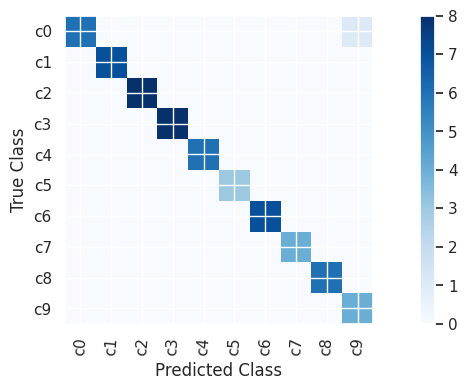

In [86]:
print("Generating predictions from validation data...")
# Getting the image and label arrays for the first batch of validation data
x_test = validation_generator[0][0]
y_test = validation_generator[0][1]

# Using the model to predict the class
class_probabilities = model.predict(x_test)

# The model returns a probability value for each class, the highest probability is the predicted class
predictions = np.argmax(class_probabilities, axis=1)

# The actual labels are hot encoded (e.g. [0 1 0], so get the one with the value 1
true_labels = np.argmax(y_test, axis=1)

# Plotting the confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=85)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

In [87]:
# Computing Precision
precision = precision_score(true_labels, predictions, average='weighted')
print("Precision: ", precision)

# Computing Recall
recall = recall_score(true_labels, predictions, average='weighted')
print("Recall: ", recall)

# Computing Accuracy
accuracy = accuracy_score(true_labels, predictions)
print("Accuracy: ", accuracy)

Precision:  0.9866666666666667
Recall:  0.9833333333333333
Accuracy:  0.9833333333333333


In [88]:
# Sving the trained model
modelFileName = 'VGG16-classifier-adam1'

model.save(modelFileName)
print("Model saved.")

del model  # deletes the existing model variable

Model saved.


## Model Application: Predicting New Data with VGG16 (Batch 60 - Adam - α = 0.005)

After training and evaluating the model, it can now be used to infer the class labels for a new set of images.

### Preparing the Images
To ensure compatibility with the model, new images need to be resized to match the dimensions that the model was trained on. This involves creating a function that resizes any incoming image to the desired dimensions.


In [97]:
# Helper function to resize image
def resize_image(src_img, size=(224, 224), bg_color="white"):
    from PIL import Image

    # Rescaling the image so the longest edge is the right size
    src_img.thumbnail(size, Image.ANTIALIAS)

    # Creating a new image of the right shape
    new_image = Image.new("RGB", size, bg_color)

    # Pasting the rescaled image onto the new background
    new_image.paste(src_img, (int((size[0] - src_img.size[0]) / 2), int((size[1] - src_img.size[1]) / 2)))

    # Returning the resized image
    return new_image

In [98]:
# Function to predict the class of an image
def predict_image(classifier, image_array):
    import numpy as np

    # Formatting the input to match the training data
    # Loading the values as floating point numbers through data generator
    # Normalizing the pixels
    img_features = image_array.astype('float32')
    img_features /= 255

    # Predicting the class of each input image
    predictions = classifier.predict(img_features)

    predicted_classes = []
    for prediction in predictions:

        # The prediction for each image is the class with the highest probability
        # Getting the index of the highest probability.
        class_idx = np.argmax(prediction)

        # Appending the corresponding class name to the results
        predicted_classes.append(class_labels[int(class_idx)])

    # Returning the predictions
    return predicted_classes

print("Functions created - ready to use model for inference.")

Functions created - ready to use model for inference.


## Predicting Image Classes

In [95]:
# Loading the Model 2
model_2 = load_model('VGG16-classifier-adam1')

1/1 [==============================] - 0s 22ms/step


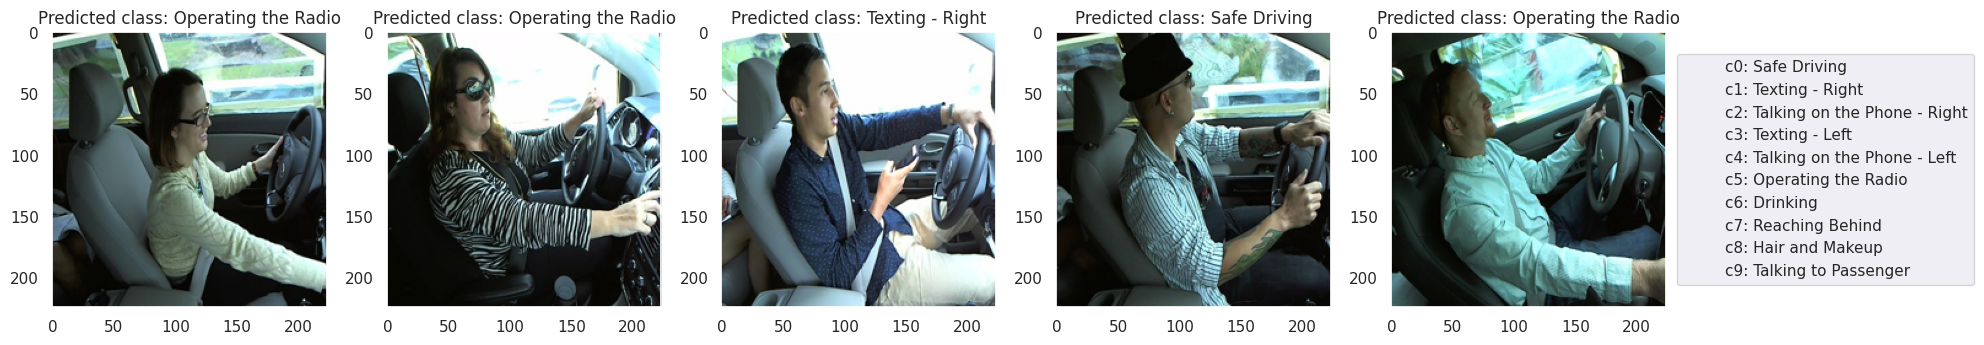

In [99]:
# Creating a function to display sample predictions
def display_sample_predictions(model, test_folder_path, activity_classes, image_size=(224, 224)):

    # Getting a list of all files in the testing folder
    test_images = os.listdir(test_folder_path)

    # Selecting 5 random images
    selected_images = random.sample(test_images, 5)

    plt.figure(figsize=(20,10))

    # For each selected image:
    for i, image_name in enumerate(selected_images):

        # Opening the image file
        img_path = os.path.join(test_folder_path, image_name)
        img = Image.open(img_path)

        # Resizing the image and convert to array
        img_resized = img.resize(image_size)
        img_array = np.array(img_resized)[np.newaxis, :]

        # Normalizing array
        img_array = img_array.astype('float32') / 255.0

        # Predicting the image class
        pred = model.predict(img_array)
        class_idx = np.argmax(pred)

        # Adding 'c' to the class index
        class_name = activity_classes[f'c{class_idx}']

        # Plotting the image with its predicted class
        plt.subplot(1, 5, i + 1)
        plt.imshow(img_array[0])
        plt.title(f'Predicted class: {class_name}')
        plt.grid(False)

    # Addding a legend with class labels
    import matplotlib.patches as mpatches
    legend_patches = [mpatches.Patch(color='none', label=f'{k}: {v}') for k, v in activity_classes.items()]
    plt.legend(handles=legend_patches, bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)

    plt.tight_layout()
    plt.show()

# Calling the function with the model and testing folder path
display_sample_predictions(model_2, images_path_test, activity_classes)

## Conclusion

The VGG16 model developed during this investigation achieved remarkable performance metrics, with precision, recall, and accuracy scores of 0.9866, 0.9833, and 0.9833, respectively. The model's robust validation scores attest to its effective capability to classify the target objects within the images.

During the testing phase, the model identified 5 out of 5 images correctly, underlining its effectiveness and potential for application on a broader scale. The Adam optimizer, with a learning rate of 0.005, facilitated swift model convergence.

In summary, this investigation yielded promising results and revealed opportunities for refining the model's performance in future iterations.
